# Asses the Impact of Variation of the Generation on the Power Flow Results

### Create the Network

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('..')
from thesis_package import utils, extractor as ex, elements as el, powerflow as pf, metrics as my_metrics, aimodels as my_ai
# RMSE
from sklearn.metrics import mean_squared_error

d:\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if 'network.pickle' not in os.listdir('..'):
    # Create a network from the data.
    network = el.Network()
    network.create_network_from_xlsx(xlsx_file_path="\data\\raw\\Data_Example_32.xlsx")
    # Create the pandapower network.
    network.create_pandapower_model() # Property name: net_model.
    # Plot the network.
    network.plot_network()
    # Method that receives the .csv files folder and adds the gen profile to the grid elements.
    network.add_generation_profiles(generation_profiles_folder_path='.\data\processed\production')
    # Method that receives a .csv files folder and adds the load profile to the grid elements.
    network.add_load_profiles(load_profiles_folder_path='.\data\processed\consumption')
    # Power flow calculation
    utils.serialize_object('network', network, message='Serializing network object...')
else:
    network = utils.deserialize_object('../network', message='Deserializing network...')

Deserializing ../network... Please wait
Deserializing network...🗸 (Execution time: 0.0[s])


### Run the Power Flow Calculation with Different Variations on the Generation Values

In [3]:
# DEPRECATED
def run_gen_error_experiement(prediction_error):
    power_flow = pf.Power_Flow()
    path_to_results_folder = '..\data\paper\gen_error_experiment\prediction_error_{}'.format(prediction_error)
    try: 
        os.listdir(path_to_results_folder)
    except: 
        os.makedirs(path_to_results_folder)
    power_flow.run_timeseries_power_flow(network, path_to_results_folder=path_to_results_folder, prediction_error=prediction_error)
run_gen_error_experiement(True)
run_gen_error_experiement(False)

Element:  load_1
Gen type:  load_1
prediction error value:  0.0377
mean error signal value:  0.9621864295187256
mean difference load:  -8.142073072731911
-------
Element:  load_2
Gen type:  load_2
prediction error value:  0.0377
mean error signal value:  0.9621775571997827
mean difference load:  -3.847019840478175
-------
Element:  load_3
Gen type:  load_3
prediction error value:  0.0377
mean error signal value:  0.9623739948417086
mean difference load:  -1.7507369919201752
-------
Element:  load_4
Gen type:  load_4
prediction error value:  0.0377
mean error signal value:  0.9623070051872478
mean difference load:  -2.189547972764789
-------
Element:  load_5
Gen type:  load_5
prediction error value:  0.0377
mean error signal value:  0.9623039744673303
mean difference load:  -3.6643547297629464
-------
Element:  load_6
Gen type:  load_6
prediction error value:  0.0377
mean error signal value:  0.9622906708250193
mean difference load:  -8.502214630554654
-------
Element:  load_7
Gen type:

### Compute the RMSE of the PF Results w.r to the Ground Truth

The bus examined is the bus 16.

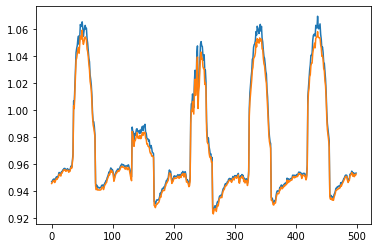

In [20]:
pf_results_pred_error = pd.read_csv('..\data\paper\gen_error_experiment\prediction_error_True\pf_res_bus_vm_pu.csv').drop('timestamps', axis=1)
pf_results_ref = pd.read_csv('..\data\paper\gen_error_experiment\prediction_error_False\pf_res_bus_vm_pu.csv').drop('timestamps', axis=1)
pf_results_pred_error['bus_16'][0:500].plot()
pf_results_ref['bus_16'][0:500].plot()
plt.show()

In [21]:
result_rmse = mean_squared_error(pf_results_ref['bus_16'], pf_results_pred_error['bus_16'],  squared=False)
result_rmse

0.004368120661444177

In [22]:
error = pf_results_ref['bus_16'] - pf_results_pred_error['bus_16']
error.mean()

-0.003434155770913859

## Compute the Difference in the Number of Constraints w.r to the Ground Truth

In [23]:
def get_boolean_datasets(path_to_pf_res_bus):
    res_bus_vm_pu = pd.read_csv(path_to_pf_res_bus)
    res_bus_vm_pu.drop('timestamps', axis=1, inplace=True) 
    # Max bus_vm_pu constraint
    res_bus_vm_pu_max_constr = res_bus_vm_pu.apply(lambda x: (x - 1.05).apply(lambda y: max(0, y)))
    # Min bus_vm_pu constraint
    res_bus_vm_pu_min_constr = res_bus_vm_pu.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
    # Compute thresholds
    max_u_threshold = utils.compute_threshold(res_bus_vm_pu_max_constr)
    min_u_threshold = utils.compute_threshold(res_bus_vm_pu_min_constr)
    turn_boolean = lambda df, threshold: df.apply(lambda x: x.apply(lambda y: 1 if y > threshold else 0))
    # Create boolean data sets
    res_bus_vm_pu_max_bool_constr = turn_boolean(res_bus_vm_pu_max_constr, utils.compute_threshold(res_bus_vm_pu_max_constr))
    res_bus_vm_pu_min_bool_constr = turn_boolean(res_bus_vm_pu_min_constr, utils.compute_threshold(res_bus_vm_pu_min_constr))
    return res_bus_vm_pu_max_bool_constr, res_bus_vm_pu_min_bool_constr
# Pred
max_u_bool_df, min_u_bool_df = get_boolean_datasets('..\data\paper\gen_error_experiment\prediction_error_True\pf_res_bus_vm_pu.csv')
max_u_bool_df.to_csv('..\data\paper\gen_error_experiment\prediction_error_True\\bool_df_max_u.csv', index=False)
min_u_bool_df.to_csv('..\data\paper\gen_error_experiment\prediction_error_True\\bool_df_min_u.csv', index=False)
# Ref
max_u_bool_df, min_u_bool_df = get_boolean_datasets('..\data\paper\gen_error_experiment\prediction_error_False\pf_res_bus_vm_pu.csv')
max_u_bool_df.to_csv('..\data\paper\gen_error_experiment\prediction_error_False\\bool_df_max_u.csv', index=False)
min_u_bool_df.to_csv('..\data\paper\gen_error_experiment\prediction_error_False\\bool_df_min_u.csv', index=False)

In [24]:
result_num_constr = pd.DataFrame(index=["max_u", "min_u"], columns=["Pred_Error", "Ref"])
file_token_name = lambda col: True if col == "Pred_Error" else False
for col in result_num_constr.columns:
    max_u_bool = pd.read_csv('..\data\paper\gen_error_experiment\prediction_error_{}\\bool_df_max_u.csv'\
        .format(file_token_name(col)))
    result_num_constr.loc['max_u'][col] = max_u_bool['bus_16'][max_u_bool['bus_16'] == 1].count()
    min_u_bool = pd.read_csv('..\data\paper\gen_error_experiment\prediction_error_{}\\bool_df_min_u.csv'\
        .format(file_token_name(col)))
    result_num_constr.loc['min_u'][col] = min_u_bool['bus_16'][min_u_bool['bus_16'] == 1].count()
result_num_constr

,Pred_Error,Ref
max_u,5115,3356
min_u,5210,6773


### Use variations as "Predictions"

In [27]:
# Obtain violation signals.
# Ref constraint signal
min_constr_ref = pf_results_ref.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
max_constr_ref = pf_results_ref.apply(lambda x: (x - 1.05).apply(lambda y: max(0, y)))
# Pred error constraint signal
min_constr_pred_error = pf_results_pred_error.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
max_constr_pred_error = pf_results_pred_error.apply(lambda x: (x - 1.05).apply(lambda y: max(0, y)))
# # Compute thresholds
max_threshold = utils.compute_threshold(max_constr_ref)
min_threshold = utils.compute_threshold(min_constr_ref)
print('max_threshold: ', max_threshold)
print('min_threshold: ', min_threshold)

max_threshold:  0.0016415810739612586
min_threshold:  0.002021374247225033


In [28]:
# Compute scores max u.
max_u_metric = my_metrics.Metrics()
max_u_metric.get_prediction_scores(max_constr_pred_error, max_constr_ref, max_threshold)
# Compute score min u.
min_u_metric = my_metrics.Metrics()
min_u_metric.get_prediction_scores(min_constr_pred_error, min_constr_ref, min_threshold)

true_positives_ctr:  22260
true_negatives_ctr:  1497266
false_positives_ctr:  17818
false_negatives_ctr:  0
2023796663193707680320
true_positives_ctr:  26063
true_negatives_ctr:  1501770
false_positives_ctr:  0
false_negatives_ctr:  9511
2104290776343733763940


In [29]:
# Showcase results
# Max u
max_u_accuracy = max_u_metric.hybrid_accuracy
max_u_precision = max_u_metric.hybrid_precision
max_u_recall = max_u_metric.hybrid_recall
max_u_f1 = max_u_metric.hybrid_f1
max_u_mcc = max_u_metric.hybrid_mcc
max_u_evaluation = pd.Series({ 'accuracy': max_u_accuracy, 'precision': max_u_precision, 'recall': max_u_recall, 'f1': max_u_f1, 'mcc': max_u_mcc })
# Min u
min_u_precision = min_u_metric.hybrid_precision
min_u_accuracy = min_u_metric.hybrid_accuracy
min_u_recall = min_u_metric.hybrid_recall
min_u_f1 = min_u_metric.hybrid_f1
min_u_mcc = min_u_metric.hybrid_mcc
min_u_evaluation = pd.Series({ 'accuracy': min_u_accuracy, 'precision': min_u_precision, 'recall': min_u_recall, 'f1': min_u_f1, 'mcc': min_u_mcc })
pd.DataFrame([max_u_evaluation, min_u_evaluation], index=['max_u', 'min_u'])

,accuracy,precision,recall,f1,mcc
max_u,0.988341,0.551909,1.00000,0.711265,0.738499
min_u,0.993801,1.000000,0.73191,0.845206,0.852816


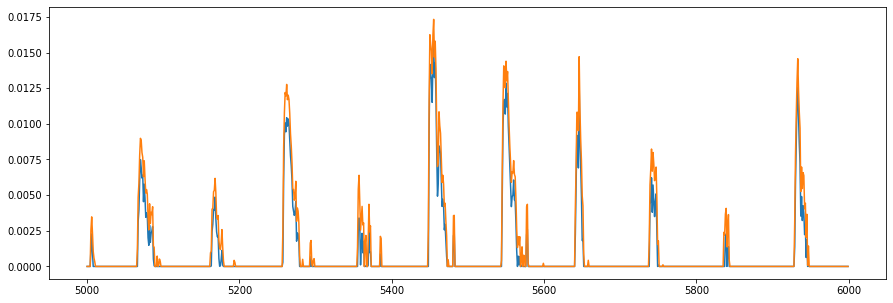

In [47]:
plt.figure(figsize=(15,5))
min_constr_pred_error['bus_16'][5000:6000].plot()
min_constr_ref['bus_16'][5000:6000].plot()
plt.legend(['Pred_error', 'Ref'])
plt.show()

for bus 16

In [52]:
# For bus 16
# Compute scores max u.
max_u_metric = my_metrics.Metrics()
max_u_metric.get_prediction_scores(pd.DataFrame(max_constr_pred_error['bus_16']), pd.DataFrame(max_constr_ref['bus_16']), max_threshold)
# Compute score min u.
min_u_metric = my_metrics.Metrics()
min_u_metric.get_prediction_scores(pd.DataFrame(min_constr_pred_error['bus_16']), pd.DataFrame(min_constr_ref['bus_16']), min_threshold)
# Showcase results
# Max u
max_u_accuracy = max_u_metric.hybrid_accuracy
max_u_precision = max_u_metric.hybrid_precision
max_u_recall = max_u_metric.hybrid_recall
max_u_f1 = max_u_metric.hybrid_f1
max_u_mcc = max_u_metric.hybrid_mcc
max_u_evaluation = pd.Series({ 'accuracy': max_u_accuracy, 'precision': max_u_precision, 'recall': max_u_recall, 'f1': max_u_f1, 'mcc': max_u_mcc })
# Min u
min_u_precision = min_u_metric.hybrid_precision
min_u_accuracy = min_u_metric.hybrid_accuracy
min_u_recall = min_u_metric.hybrid_recall
min_u_f1 = min_u_metric.hybrid_f1
min_u_mcc = min_u_metric.hybrid_mcc
min_u_evaluation = pd.Series({ 'accuracy': min_u_accuracy, 'precision': min_u_precision, 'recall': min_u_recall, 'f1': min_u_f1, 'mcc': min_u_mcc })
pd.DataFrame([max_u_evaluation, min_u_evaluation], index=['max_u', 'min_u'])

true_positives_ctr:  3356
true_negatives_ctr:  39988
false_positives_ctr:  1872
false_negatives_ctr:  0
29368816010410240
true_positives_ctr:  5169
true_negatives_ctr:  38443
false_positives_ctr:  0
false_negatives_ctr:  1604
53898275154973977


,accuracy,precision,recall,f1,mcc
max_u,0.958323,0.638527,1.00000,0.779392,0.780897
min_u,0.964447,1.000000,0.76249,0.865242,0.855504


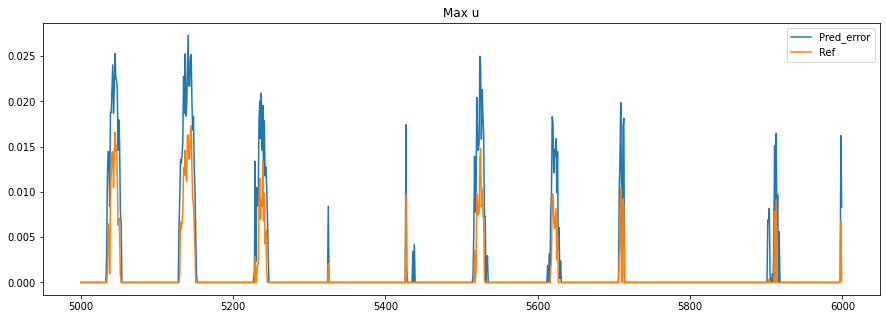

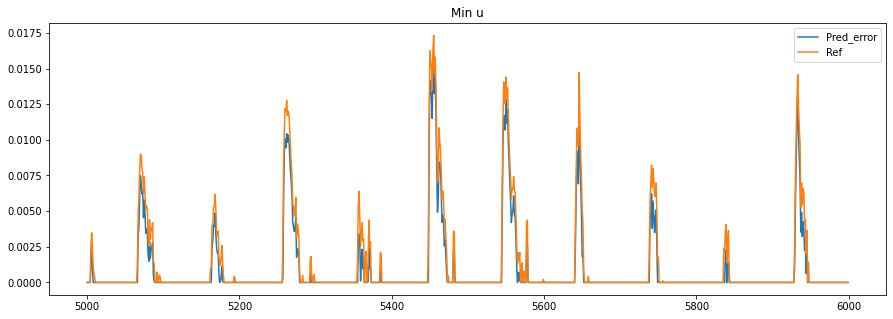

In [53]:
plt.figure(figsize=(15,5))
max_constr_pred_error['bus_16'][5000:6000].plot()
max_constr_ref['bus_16'][5000:6000].plot()
plt.legend(['Pred_error', 'Ref'])
plt.title('Max u')
plt.show()
plt.figure(figsize=(15,5))
min_constr_pred_error['bus_16'][5000:6000].plot()
min_constr_ref['bus_16'][5000:6000].plot()
plt.legend(['Pred_error', 'Ref'])
plt.title('Min u')
plt.show()